# *Aufgabe: Advanced Metriken and Hypereparameteroptimierung*

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import os

### Aufgabe 1. Advanced Metrics


Für den Census Datensatz trainieren Sie zwei Klassifizierungsmodelle Ihrer Wahl und berechnen Sie für sie neben der Akkuranz auch Precision und Recall. Plotten Sie mithilfe von sklearn zusätzlich je einen ROC-Graphen.


In [2]:
# Vorbereitung wie in den vorherigen Notebooks
census = pd.read_csv(os.path.join("..", "..", "..", "data", "census.csv"))
census = census.drop(['occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country', 'workclass', 'marital-status'], axis=1)

# Encoding:
# SEX: Male: 1, Female: 0
census["sex"] = census["sex"].replace({' Male': 1, ' Female': 0})

# TARGET: >50K: 1, <=50K: 0
census["target"] = census["target"].replace({' >50K': 1, ' <=50K': 0})

to_encode = ['education', 'race']
for feature in to_encode:
    one_hot = pd.get_dummies(census[feature], drop_first=True)
    census = census.join(one_hot)
    census.pop(feature)

/var/folders/6z/jr7vc1n52qlbyvvf98jx_y580000gn/T/ipykernel_7769/2926189982.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  census["sex"] = census["sex"].replace({' Male': 1, ' Female': 0})
/var/folders/6z/jr7vc1n52qlbyvvf98jx_y580000gn/T/ipykernel_7769/2926189982.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  census["target"] = census["target"].replace({' >50K': 1, ' <=50K': 0})


In [3]:
x_train, x_test, y_train, y_test = train_test_split(census.drop(["target"],axis=1),census["target"])
print('X Train: {}'.format(x_train.shape))
print('Y Train: {}'.format(y_train.shape))
print('X Test: {}'.format(x_test.shape))
print('Y Test: {}'.format(y_test.shape))

# Normalize: Age und hours-per-week
minmax = MinMaxScaler()

x_train['age'] = minmax.fit_transform(x_train['age'].to_numpy().reshape(-1,1))
x_train['hours-per-week'] = minmax.fit_transform(x_train['hours-per-week'].to_numpy().reshape(-1,1))

x_test['age'] = minmax.fit_transform(x_test['age'].to_numpy().reshape(-1,1))
x_test['hours-per-week'] = minmax.fit_transform(x_test['hours-per-week'].to_numpy().reshape(-1,1))

X Train: (24420, 22)
Y Train: (24420,)
X Test: (8141, 22)
Y Test: (8141,)


2. Train the Random Forest and kNN models:

In [ ]:
# Triviale Hypothese - schätze immer 0 als Ergebnis
predict = np.zeros(len(y_test))

# Confusionmatrix zur Darstellung der true-positiv, false-positiv, true-negativ, false-negativ
cm = confusion_matrix(predict, y_test)

print("--------------------------------- \n TRIVIALE HYPOTHESE")
print("Accuracy: {}".format(accuracy_score(predict, y_test)))
print("Confusion matrix: \n{}".format(cm))

# Random Forest:

rf = RandomForestClassifier(n_estimators=2, criterion="entropy", max_depth=1, min_samples_split=5, random_state=1)
rf.fit(x_train, y_train)
predict = rf.predict(x_test)

cm = confusion_matrix(predict, y_test)

# false-positiv, false-negativ, true-positiv werden für die weiteren Berechnungen benötigt
_, fp, fn, tp = cm.ravel()

print("--------------------------------- \n RANDOM FOREST  ")
print("Accuracy: {}".format(accuracy_score(predict, y_test)))
print("Confusion matrix: \n{}".format(cm))
print("Precision: {}".format(tp/(tp + fp)))
print("Recall: {}".format(tp/(tp + fn)))

# Erstellen der ROC Kurve basierend auf anderen Metriken
plt.figure(figsize=(8,6))
plt.title("ROC Graphs")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, rf.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="black",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph Random forest",c="#1ACC94")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")

# kNN
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(x_train, y_train)
predict = knn.predict(x_test)

cm = confusion_matrix(predict, y_test)
_, fp, fn, tp = cm.ravel()

print("--------------------------------- \n KNN  ")
print("Accuracy: {}".format(accuracy_score(predict, y_test)))
print("Confusion matrix: \n{}".format(cm))
print("Precision: {}".format(tp/(tp + fp)))
print("Recall: {}".format(tp/(tp + fn)))
fpr, tpr, _ = metrics.roc_curve(y_test.values, knn.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="black",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph kNN")

plt.legend()
plt.show()

/var/folders/6z/jr7vc1n52qlbyvvf98jx_y580000gn/T/ipykernel_7769/756652473.py:26: RuntimeWarning: invalid value encountered in scalar divide
  print("Recall: {}".format(tp/(tp + fn)))


--------------------------------- 
 TRIVIALE HYPOTHESE
Accuracy: 0.7624370470458175
Confusion matrix: 
[[6207 1934]
 [   0    0]]
--------------------------------- 
 RANDOM FOREST  
Accuracy: 0.7624370470458175
Confusion matrix: 
[[6207 1934]
 [   0    0]]
Precision: 0.0
Recall: nan


### Aufgabe 2. Hyperparameteroptimierung

Optimieren Sie eins von den beiden Modelle mithilfe von wahlweise Grid- oder Random-Search aus der sklearn Implementierung. Um wieviel verbessert sich Ihr Modell im Rahmen dieser Optimierung?

1. Optimize Random Forest with Grid Search Algorithm

In [ ]:
# Festlegen des Wertebereichs und der Schrittweite des Grids für die Hyperparameter
grid_points_n_estimators = range(1, 201, 50)
grid_points_max_depth = np.arange(1, 11)
grid_points_min_samples_split = np.arange(2, 52, 5)

# Initialisieren der besten Hyperparameter, diese werden später überschrieben
max_z = -np.inf
n_estimators, max_depth, min_samples_split = 1, 1, 2
best_point = (n_estimators, max_depth, min_samples_split)

# Loop durch alle möglichen Kombinationen
for n_estimators in grid_points_n_estimators:
    for max_depth in grid_points_max_depth:
        for min_samples_split in grid_points_min_samples_split:
            rf = RandomForestClassifier(n_estimators=n_estimators, criterion="entropy", max_depth=max_depth,
                                        min_samples_split=min_samples_split, random_state=1)
            rf.fit(x_train, y_train)
            z = accuracy_score(rf.predict(x_test), y_test)

            # falls die Accuracy höher ist als die vorherige beste, speicher die neuen Werte ab
            if z > max_z:
                max_z = z
                best_point = (n_estimators, max_depth, min_samples_split)

print(f"Bester Punkt mit z={round(max_z, 3)} gefunden bei {best_point}")

Bester Punkt mit z=0.81 gefunden bei (101, np.int64(10), np.int64(7))


ROC Graph für das verbesserte Model

Accuracy: 0.8096056995455104
Confusion matrix: 
[[5883 1265]
 [ 285  708]]
Precision: 0.35884439939178914
Recall: 0.7129909365558912


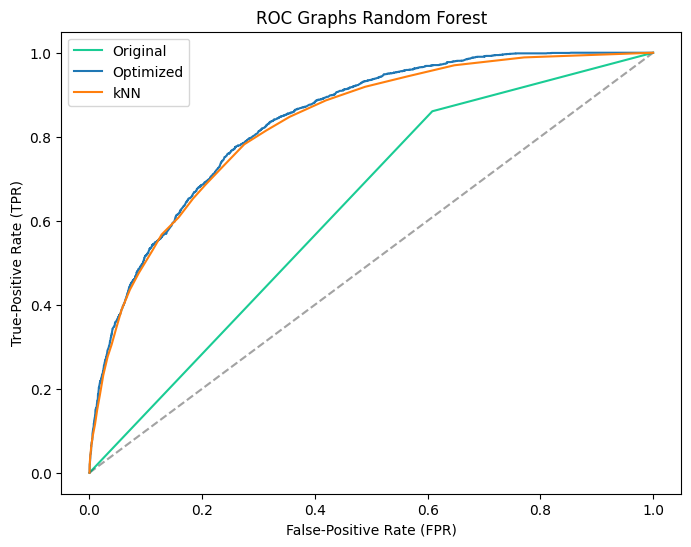

In [ ]:
# Originale Modell
rf1 = RandomForestClassifier(n_estimators=2, criterion="entropy", max_depth=1, min_samples_split=5, random_state=1)
rf1.fit(x_train, y_train)

plt.figure(figsize=(8,6))
plt.title("ROC Graphs Random Forest")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, rf1.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="black",alpha=0.2)
plt.plot(fpr,tpr,label="Original",c="#1ACC94")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")

# Optimiertes Modell
best_point = (n_estimators, max_depth, min_samples_split)
rf_opt = RandomForestClassifier(n_estimators=best_point[0], criterion="entropy", max_depth=best_point[1],
                                min_samples_split=best_point[2], random_state=1)
rf_opt.fit(x_train, y_train)
predict = rf_opt.predict(x_test)

cm = confusion_matrix(predict, y_test)
tn, fp, fn, tp = cm.ravel()

print("Accuracy: {}".format(accuracy_score(predict, y_test)))
print("Confusion matrix: \n{}".format(cm))
print("Precision: {}".format(tp/(tp + fp)))
print("Recall: {}".format(tp/(tp + fn)))
fpr, tpr, _ = metrics.roc_curve(y_test.values, rf_opt.predict_proba(x_test)[:,1:])
plt.plot(fpr,tpr,label="Optimized")

fpr, tpr, _ = metrics.roc_curve(y_test.values, knn.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="black",alpha=0.2)
plt.plot(fpr,tpr,label="kNN")
plt.legend()
plt.show()